"""
SUMMARY of notebook 

Cell  creates a QUBO Adjacency to represent the ambulance problem, it involves constraints and minimising distance driven.  

Use TwoAmbulanceChimeraEmbedding.ipynb to    Create an embedding. 


# DIAGNOSE

Cell:  Defines the methods used in Cell 3, and converts QUBO Adjacency to the dwave type bqm that can be sampled  
Cell:  Finds the minimum energy for a given starting postion of two ambulances, using a choice of a) dimod.ExactSolver() b)neal.SimulatedAnnealingSampler()   or c) DWaveSampler() the live QPU not a simulator or d) TabuSampler()  
cell:  Classically iterates over all possible starting position of two ambulances and selects the lowest energy of them all and which destination are allocated to each of the two ambulances.  

In [5]:
#TWO AMBULANCE DISTANCE MINIMISATION - 

import numpy as np 
#RC utility functions    
from pyaqc.RCModules.PlatformConversion import print_QUBOdetails, CreateTwoAmbulanceAdjacencyV1,CreateTwoAmbulanceAdjacencyV2
#################################### Create Adjacency defined as a qubo ####################################
n_destinations = 5*5
gridWidth = 5# n_destinations
Width  = gridWidth
Height = n_destinations//gridWidth

result = CreateTwoAmbulanceAdjacencyV2(gridWidth,n_destinations, Adddistance = 1, ConstraintMultiplier=66, use_XYMixer_constraints=0)

Adjacency = result['qubo']
AdjacencyHybrid = result['quboHybrid']
n_qubits = result['n_qubits']
ConstraintMultiplier = result['ConstraintMultiplier']
max_distance = result['max_distance']
sum_distance = result['sum_distance']
print(ConstraintMultiplier/max_distance ,' = ConstraintMultiplier/max_distance')
if 1:
    filename = 'Twoambulances.txt'
    
    #print_QUBOdetails(Adjacency,n_qubits,filename)

2.0625  = ConstraintMultiplier/max_distance


In [2]:
# Useful functions
import matplotlib.pyplot as plt
import dimod
samplerExact = dimod.ExactSolver()
def sum_distance_of_solution(psi_opt,Adjacency, prt_result=True):
    """
    parama
        psi_opt     a potential solution to the problem type: list[int,int...]
        Adjacency   defined as a qubo the whole ambulance problem   type: dict {(row,col): weight}

    Returns The Distance an ambulance would travel for a given psi_opt,Adjacency    type: float

    """
    Nlocs = len(psi_opt)//4
    Distance  =         -1      #default value if Distance cannot be calculated
    # presumes that there is only one A0 start position
    A0_start_pos_qubits = psi_opt[Nlocs*2:Nlocs*3]
    if A0_start_pos_qubits.count(1) ==1:
        A0_start = A0_start_pos_qubits.index(1)
    elif prt_result: print(' There are ', A0_start_pos_qubits.count(1), 'A0_start positions, there should be 1 ')
    A1_start_pos_qubits = psi_opt[Nlocs*3:Nlocs*4]
    if A1_start_pos_qubits.count(1) ==1:
        A1_start = A1_start_pos_qubits.index(1)
    elif prt_result: print(' There are ', A1_start_pos_qubits.count(1), 'A1_start positions, there should be 1 ')
    if A0_start_pos_qubits.count(1) ==1 and  A1_start_pos_qubits.count(1) ==1:
        Distance = SolutionDistance(psi_opt,A0_start,A1_start,Adjacency,Nlocs)
    return Distance
#sum_distance_of_solution(psi_opt)


def lowest_energy_num_occ(response, atol:'tolerance'=0):
    """
    Returns (type:float) the number of samples in the 'response' (type:sample_set) with energies < lowest_energy + atol
    params:  'response' (type:sample_set)
              'atol' (type:float)
          
    """
    num_occ = 0
    for data in  response.data(['num_occurrences','energy']):
            if data.energy < response.first[1]+ atol :
                num_occ += data.num_occurrences
#                print(data.energy)
            else:
#                print(data.energy)
                break
    return num_occ
def chain_length_frequency(embedding, prt_result=True):
    length_frequency= {'num_chains':0 , 'num_added_variables':0}#, 'avg_chain_len':0}
    max_len = 0
    ### Label the keys of length_frequency{}
    for key, val in embedding.items():
        max_len = max(max_len,len(val))
    length_frequency.update( { 'num_len ' + str(length):0 for length in range(2,max_len+1)})
    num_chains = 0
    sum_lengths = 0
    num_added_variables = 0
    for key, chain in embedding.items():
        length = len(chain)
        if length >1:
            length_frequency['num_len ' + str(length)] += 1
            sum_lengths += length
            num_chains += 1
            length_frequency['num_added_variables'] += length-1
        
    length_frequency['num_chains' ] = num_chains
    length_frequency.update({ 'avg_chain_len':sum_lengths / num_chains} )
    #length_frequency['avg_chain_len'] =  sum_lengths / num_chains
    average_chain_length = sum_lengths / num_chains
    if prt_result==True:
        print(length_frequency)
    #print('%3.2f'%(average_chain_length ), ' = average chain length.', max_len, ' = max_len.', num_chains, ' = total number of chains')
    return length_frequency     
       
def create_hybrid_from(Adjacency, Nlocs, A0_fix, A1_fix):
    """
    params
        A0_fix: fixed starting position for  ambulance 0
        type:int
        A1_fix: fixed starting position for  ambulance 1
        type:int
        Nlocs:  number of possible locations that need an ambulance visit
        type:int
    returns Type:dict A simplified adjacency table, (a subproblem) that uses a fixed starting position for each ambulance
    Type:dict
    """
    for L in range(0 , Nlocs):
        # remove AdjacencyHybrid distance references
        if (L, 2*Nlocs) in AdjacencyHybrid:
            del AdjacencyHybrid[(L, 2*Nlocs)] 
        if (L + Nlocs, 2*Nlocs +1) in  AdjacencyHybrid:
            del AdjacencyHybrid[(L + Nlocs, 2*Nlocs +1)] 
        
        # add first ambulance distances from fixed start to each destinations (if non-zero)
        A0_fix_to_des_key = (L, A0_fix + 2 * Nlocs) 
        if (A0_fix_to_des_key) in  Adjacency:
            AdjacencyHybrid[(L, 2*Nlocs)] = Adjacency [A0_fix_to_des_key]                 
        # then second ambulance
        A1_fix_to_des_key = (L + Nlocs, A1_fix + 3 * Nlocs )
        if (A1_fix_to_des_key) in  Adjacency:
            AdjacencyHybrid[(L + Nlocs, 2*Nlocs +1)] = Adjacency [A1_fix_to_des_key]       
    return AdjacencyHybrid
from dwave.cloud import Client
client = Client.from_config(token='DEV-d58203bae0f10bbf7a7bec839b170624758a9d5d')       #irgambler actual token
#client = Client.from_config(token='DEV-f94593d3e9df93c9227b0caeeae3734e793b8feb')       #rcgquantum@gmail.com account token
client.get_solvers()
#(dwave_3.7.9py_1.18.5num_env) C:\Users\Robert>dwave config create then change token in MyDwave configuration

#client.config()     #FAILS
client.token
# typical chain breaks per occurance in top 1000 occurances ranked by energy =  0.015
RC_embedding = {12: (997, 4309, 4310), 13: (1012, 4294, 4295), 14: (1027, 4250), 15: (1042, 4235), 16: (1057,), 17: (1072,), 0: (4325,), 1: (4340,), 2: (4355,), 3: (4370,), 4: (4385,), 5: (4400,), 18: (1177, 4416), 19: (1192, 4431), 20: (1207, 4251, 1208), 21: (1222, 4236, 1223), 22: (1237, 1238), 23: (1252, 1253), 6: (4326,), 7: (4341,), 8: (4356,), 9: (4371,), 10: (4386,), 11: (4401,)}

chain_length_frequency(RC_embedding)

DWave_pegasus_embedding1 = {0: (2661,), 6: (4064, 2556), 13: (4169, 2736), 14: (4154, 2706), 15: (4124, 4123), 16: (4139, 4138), 17: (2631, 4199), 19: (2585,), 20: (4003, 2571, 2495), 21: (3958, 2615), 22: (2600,), 23: (4034, 2660), 2: (2721, 2722), 3: (2781, 2780), 4: (2646, 2645), 5: (2691,), 12: (4184, 2616), 1: (2676, 2675), 7: (4019, 4018), 18: (2630, 4093), 8: (4049,), 9: (3974, 3973), 10: (3943,), 11: (4079,)} 

# typical chain breaks per occurance in top 1000 occurances ranked by energy =  0.0190
chain_length_frequency(DWave_pegasus_embedding1)
#
embed_for_9location = {0: (990, 991), 9: (3049, 3048), 19: (1051, 3320, 1050), 20: (3200, 3199, 1170), 21: (3229, 3230, 1201), 22: (3156, 3155), 23: (3215, 3214, 1126), 24: (3170, 3171), 25: (1111, 3260), 26: (1096, 3245), 28: (811, 810, 3274), 29: (3109, 825), 30: (885, 2974, 886), 31: (916, 3169, 915), 32: (901, 900, 3154), 33: (841, 840), 34: (931, 3259, 930), 35: (856, 855), 2: (1082, 1081, 3350), 3: (1155, 3110, 3050), 4: (3321, 1140, 1141), 5: (1021, 1020), 6: (3185, 1185), 7: (3140, 946), 8: (1005, 1006), 18: (1065, 1066, 3290), 1: (1036, 1035), 10: (3125, 3124), 27: (871, 870, 3289), 11: (961, 3244), 12: (3064, 3065), 13: (3079, 3080), 14: (3095, 3094), 15: (3184, 3183), 16: (3139,), 17: (3034, 3033)}
chain_length_frequency(embed_for_9location)
embed_for_9location1 = {0: (989, 5614, 5719, 988), 9: (5720, 5721, 1199), 19: (824, 823, 5568), 20: (883, 884, 5404), 21: (929, 5509, 5569), 22: (854, 853), 23: (5524, 5523, 973), 24: (959, 5599), 25: (944, 5584), 26: (899, 898, 5644), 28: (1244, 5601), 29: (5586, 1229), 30: (1168, 1169, 5496), 31: (5617, 5616, 1409, 5615), 32: (5662, 1394, 5661), 33: (5571, 5570, 1319), 34: (5526, 5525, 1363, 1364), 35: (1334, 5630, 5631, 1333), 2: (5465, 5464, 5466), 3: (5538, 5539, 5540), 4: (5434, 5435), 5: (5480, 5479), 6: (974, 5629, 5690), 7: (5554, 5553, 1034), 8: (5449, 5450, 5451), 18: (869, 868), 1: (5494, 5495), 10: (5585, 1154, 1094), 27: (1424, 1259, 5646, 5647), 11: (1289, 5541), 12: (1214,), 13: (5511, 5512, 1153), 14: (1274, 5556, 5481), 15: (5692, 1349, 5691), 16: (5555, 1184, 1079), 17: (1304, 5497)} 
chain_length_frequency(embed_for_9location1)

# an embedding that had a low (0.72)number of breaks in the first 1000 lowest energy occurances.
DWave_chimera_embedding = {0: (1163, 1291, 1035), 6: (1286, 1294, 1288, 1416), 13: (1043, 1171, 1047, 1039), 14: (1172, 1164, 1180, 1179), 15: (1054, 1046, 1049, 1177, 1038), 16: (1182, 1166, 1174, 1160), 17: (1167, 1183, 1175), 19: (1281, 1409, 1537), 20: (1540, 1548, 1536, 1544), 21: (1412, 1420, 1417, 1545), 22: (1418, 1546, 1421, 1413), 23: (1411, 1539, 1283, 1541), 2: (1162, 1290, 1034, 1292), 3: (1161, 1289, 1033, 1293), 4: (1297, 1169, 1041, 1425, 1553), 5: (1298, 1170, 1042, 1426, 1554), 12: (1165, 1173, 1168, 1040), 1: (1306, 1178, 1181, 1434, 1562), 7: (1549, 1557, 1565), 18: (1419, 1547, 1414, 1422), 8: (1284, 1282, 1410), 9: (1285, 1280, 1408), 10: (1542, 1550, 1558), 11: (1543, 1551, 1559)}

# an embedding that had a low (0.002)number of breaks in the first 1000 lowest energy occurances.
DWave_chimera_embedding1 ={0: (1765, 1762, 1773), 6: (1895, 1890), 13: (1635, 1644, 1636, 1763), 14: (1768, 1775, 1640), 15: (1758, 1626, 1766, 1774, 1754), 16: (1756, 1764, 1772, 1752, 1624), 17: (1629, 1645, 1637, 1634), 19: (2019, 1891, 2021, 2029), 20: (1909, 1901, 1905, 2033, 1893), 21: (1892, 1900, 1908, 1904, 2032), 22: (1896, 2024, 1902, 1894), 23: (2028, 2020, 2036, 2018), 2: (1633, 1761), 3: (1642, 1770), 4: (1643, 1771), 5: (1760, 1632, 1767), 12: (1630, 1646, 1638), 1: (1769, 1641), 7: (1897, 2025), 18: (2031, 2039, 2023), 8: (1889, 2017), 9: (1898, 2026), 10: (1899, 2027), 11: (1888, 2016)} 
chain_length_frequency(DWave_chimera_embedding)
chain_length_frequency(DWave_chimera_embedding1)
#nodes_not_in_sampler, holes_in_focus,qpu_focus = sampler_node_not_in_chimera_graph(structured_sampler)

{'num_chains': 10, 'num_added_variables': 14, 'num_len 2': 6, 'num_len 3': 4, 'avg_chain_len': 2.4}
{'num_chains': 17, 'num_added_variables': 18, 'num_len 2': 16, 'num_len 3': 1, 'avg_chain_len': 2.0588235294117645}
{'num_chains': 35, 'num_added_variables': 49, 'num_len 2': 21, 'num_len 3': 14, 'avg_chain_len': 2.4}
{'num_chains': 35, 'num_added_variables': 64, 'num_len 2': 11, 'num_len 3': 19, 'num_len 4': 5, 'avg_chain_len': 2.8285714285714287}
{'num_chains': 24, 'num_added_variables': 68, 'num_len 2': 0, 'num_len 3': 8, 'num_len 4': 12, 'num_len 5': 4, 'avg_chain_len': 3.8333333333333335}
{'num_chains': 24, 'num_added_variables': 51, 'num_len 2': 10, 'num_len 3': 5, 'num_len 4': 5, 'num_len 5': 4, 'avg_chain_len': 3.125}


{'num_chains': 24,
 'num_added_variables': 51,
 'num_len 2': 10,
 'num_len 3': 5,
 'num_len 4': 5,
 'num_len 5': 4,
 'avg_chain_len': 3.125}

2256 = TimeTakenWallClock taken (secs) by simAnneal
StartPositionsA0
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
			 Start Position A0 Constraints met
StartPositionsA1
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 1, 0]
[0, 0, 0, 0, 0]
[0, 0, 0, 0, 0]
 			Start Position A1 Constraints met
-1717.0  = Lowest energy found by simAnneal  in a grid 5 (w) by 5 (h)
Destination Constraints were Met.
 Map of destinations of each ambulance, 1 for A0, 0 for A1. Where A0 starts add 10, A1 add 20
[1, 1, 1, 0, 0]
[1, 1, 1, 0, 0]
[1, 11, 0, 20, 0]
[1, 1, 1, 0, 0]
[1, 1, 0, 0, 0]
Distance of solution =  65	With A0_sol = 11 and A1_sol = 13
 ConstraintMultiplier/max_distance =  2.0625
10  = number of occurances of the lowest energy found. Using num_shots =  900000 
0.00 = % Probability that this energy level was found by one anneal, ie num_shot=1
900000 len (List of  energies UNORDERED)
Grid            Energy          Distance       Errs           Constraintmet  Method    

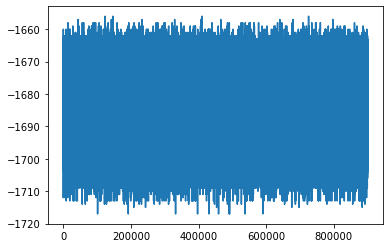

In [7]:
#This cell creates a Ising model, from a qubo defined adjacency, where the starting positions of the two  ambulances have been specified by the user
# eg Amulance 'zero' starts location number 4 so set A0_fix=4
#Then this cell finds the lowest energy waveform using one of three different minimisation approaches    
#Cell 3 Finds the minimum energy for a given starting postion of two ambulances, using a choice of a)dimod.ExactSolver() b)neal.SimulatedAnnealingSampler()   or c) DWaveSampler()
UseHybrid = 0
sampler_choice = {0:'samplerExact',1:'simAnneal',2:'DWave_pegasus',3:'DWave_chimera',4: 'Tabu'}
#sampler_choice = ['samplerExact','simAnneal','DWave_pegasus','DWave_chimera', 'Tabu']
Method = sampler_choice[1]
Num_readsMy = 900000     # SolverFailureError: The parameter num_reads must be within [1, 10000] for the qpu
my_prefactor = 1.3 #1.414 default value
use_Composite_embedding = 0 # use sampler = EmbeddingComposite(child_sampler=structured_sampler) otherwise,  supply a working embedding of the problem, eg embedding = {12: (997, 4309, 4310), 13: (1012, 4294, 4295), ...} and use  FixedEmbeddingComposite(structured_sampler, embedding)
if 1: embedding = DWave_chimera_embedding1
if 0: embedding = RC_embedding
if 0: embedding = DWave_pegasus_embedding1
if 0:  embedding = embed_for_9location1

use_anneal_schedule = 1
anneal_scheduleMy = [[0,0],  [200, 1]] #[10, 0.4], [40, 0.6],
################# Main minimisation of the subproblem #################
from datetime import datetime
from pyaqc.RCModules.TwoAmbulanceAnalysis import *
tstart = datetime.now()
if Height==2 and Width==2:
    A0_fix = 1
    A1_fix = 2
if Height==3 and Width==3:
    A0_fix = 1
    A1_fix = 7
if Height==5 and Width==5: #On inspection 7, 17 is the optimized distance start positions for 5*5
    A0_fix = 7 #22                          # a 10*5 grid has a more obvious solution by inspection 22,27
    A1_fix=  17 # 27#  16,32  40  
if Height==7 and Width==7:      #I need to check this is the optimum position of the ambulances
    A0_fix = 16
    A1_fix = 32                   
ConstraintMet = 1
Nlocs = Height*Width
MinE = 0

if UseHybrid:
    AdjacencyHybrid = create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix )
    Myqubo = dimod.BinaryQuadraticModel.from_qubo(AdjacencyHybrid)       #use quboHybrid with given A0_fix and A1_fix
else:
    Myqubo = dimod.BinaryQuadraticModel.from_qubo(Adjacency)             #use Adjacency with all starting positions

############ Use one of three possible samplers
    # a)samplerExact(calculated every possible combination of ambulance start positions)
    # b)SimulatedAnnealingSampler()  (classically imitates a Dwave annealer)
    # c)sampler = EmbeddingComposite(DWaveSampler()) , the real online Dwave annealer

if Method == sampler_choice[0]:       # 'samplerExact'
    response = samplerExact.sample(Myqubo) 
    Num_readsMy = 1
    energy = response.first[1]
    TimeTaken = 'QPU not used'
    
if Method == sampler_choice[1]: # Method == 'simAnneal'
    import neal
    solver = neal.SimulatedAnnealingSampler()  
    response = solver.sample(Myqubo, num_reads=Num_readsMy)
    plt.plot(response.data_vectors['energy'])
    TimeTaken = 'QPU not used'

from dwave.system import FixedEmbeddingComposite
from dwave.system.samplers import DWaveSampler
from dwave.system.composites  import EmbeddingComposite

#### select sampler from  'DWave_pegasus','DWave_chimera'

if Method == sampler_choice[2]: # DWAVE online annealing Method = 'DWave_pegasus'
    structured_sampler = DWaveSampler(solver={'topology__type': 'pegasus'})        #'chimera ', 'pegasus'
    
if Method == sampler_choice[3]: # DWAVE online annealing Method = 'DWave_chimera' with anneal_scheduleMy
    structured_sampler = DWaveSampler(solver={'topology__type': 'chimera'})      #'chimera ', 'pegasus'
#### Set Chain strength  for QPU  
if (Method == sampler_choice[2] or  Method == sampler_choice[3]) and 1:
    
    from dwave.embedding.chain_strength import uniform_torque_compensation      #prefactor * rms * math.sqrt(avg_degree)
    if my_prefactor > 0:
        chain_strength_value = uniform_torque_compensation(Myqubo.spin, embedding=None, prefactor=my_prefactor)
    else:
        chain_strength_value = 1
    
#### Set embedding
    if use_Composite_embedding :
        sampler = EmbeddingComposite(structured_sampler)
    else:
        sampler = FixedEmbeddingComposite(structured_sampler, embedding)
    if use_anneal_schedule:
        response = sampler.sample(Myqubo, num_reads=Num_readsMy,return_embedding=True,chain_strength=chain_strength_value,anneal_schedule=anneal_scheduleMy)#, anneal_schedule=anneal_scheduleMy)
    else:
        response = sampler.sample(Myqubo, num_reads=Num_readsMy,return_embedding=True,chain_strength=chain_strength_value)
### Record chargeable QPU time
    print(response.info['timing']['qpu_access_time']/1000 , ' = qpu_access_time/ msec')    
    TimeTaken = response.info['timing']['qpu_anneal_time_per_sample']
    TimeTaken = '$'+ str(TimeTaken) +'\mu$s'

from tabu import TabuSampler
if Method == sampler_choice[4]:     #'Tabu'
    response = TabuSampler().sample(Myqubo, num_reads=Num_readsMy)
    TimeTaken = 'QPU not used'
TimeTakenWallClock = (datetime.now() - tstart).seconds
print(TimeTakenWallClock, '= TimeTakenWallClock taken (secs) by', Method)
# Find Start positions in the solution
psi_opt = list( response.first[0].values())
if not UseHybrid and 1:
    A0_sol  =   Grid_StartPositionsAO(psi_opt,  Height,Width)
    A1_sol  =   Grid_StartPositionsA1(psi_opt,  Height,Width)
else:
    A0_sol = A0_fix
    A1_sol  = A1_fix
Print_Destinations(response, Height,Width,Method, A0_sol, A1_sol,show_start_pos=1)
if A0_sol>=0 and  A1_sol>=0:
    Distance = SolutionDistance(psi_opt,A0_sol,A1_sol,Adjacency,Nlocs)
    print('Distance of solution = ', Distance, end='')
else:
    print('Start positions not found')
    Distance = -1
print( '\tWith A0_sol =',A0_sol,'and A1_sol =',A1_sol)
print( ' ConstraintMultiplier/max_distance = ', ConstraintMultiplier/max_distance  )
if 1:
    repeats = lowest_energy_num_occ(response,0.01)
    print(repeats, " = number of occurances of the lowest energy found. Using num_shots =  {0:4} ".format( Num_readsMy )  )
    print('%3.2f'%(repeats*100/Num_readsMy), '= % Probability that this energy level was found by one anneal, ie num_shot=1')
    print(len(response.data_vectors['energy']), 'len (List of  energies UNORDERED)')

    print(              '{:15} {:15} {:15}{:15}{:15}{:15}{:15}{:15}{:15}{:15}'.format('Grid','Energy', 'Distance', 'Errs','Constraintmet','Method', 'Lagrange K', 'num_reads ', 'time', 'my_prefactor'),end=''  )
    print("\n|{:<2} {:<1}{:<1}|{:>14}|{:15}|0 |{:>15}|{:>15s}| {:15}|{:15}|{:15}|".format(Width,'* ',Height,response.first[1],Distance,ConstraintMet, Method,ConstraintMultiplier/max_distance,Num_readsMy,TimeTaken) ,end='')
    print(repeats,'(', '%3.2f'%(repeats*100/Num_readsMy),'%)|', '%3.2f'%my_prefactor,'|')
if 0:
    print(response.info['embedding_context']['chain_strength']  )

In [76]:
# Display chain break for each potential solution in order of 'energy'
print('UNPACK each sample from the sampleSet, in ORDER of (energy, or of evaluations)  into\n', 'Sample', '\t\t\t\t\t\tenergy','\tnum_occurrences', 'chain_break_fraction')

from pyaqc.RCModules.TwoAmbulanceAnalysis import  qubo_energy_value,Grid_Destinations, Grid_StartPositionsAO,Grid_StartPositionsA1,SolutionDistance, Print_Destinations

# 'chain_break_fraction' definition = for a given suggested solution, the number of chains broken / n_qubits
avg_num_chain_breaks = 0
sum_num_occurrences = 0
max_occurances = 1000
num_distance_not_calc = 0
for n,datum in enumerate( response.data(fields=['sample', 'energy','num_occurrences'], sorted_by='energy')):     #'energy''chain_break'
    if sum_num_occurrences < max_occurances:
        if sum_num_occurrences < repeats or 0:
            sum_num_occurrences += datum.num_occurrences
            psi_opt = list(datum.sample.values())
            Distance  =    sum_distance_of_solution(psi_opt,Adjacency, prt_result=False)
            if Distance == -1:
                num_distance_not_calc +=1
print(num_distance_not_calc, ' Solutions distance calculations were not possible given the  lowest energy psi_opt (s)')
for n,datum in enumerate( response.data(fields=['sample', 'energy','num_occurrences','chain_break_fraction'], sorted_by='energy')):     #'energy''chain_break'
    if sum_num_occurrences < max_occurances:
        if n<20 or 0:
            psi_opt = list(datum.sample.values())
            print(list(datum.sample.values() ), '\t', '%4.4f'%datum.energy ,'\t', datum.num_occurrences,'\t','%4.4f'%datum.chain_break_fraction,'\t',sum_distance_of_solution(psi_opt,Adjacency, prt_result=False))
        avg_num_chain_breaks += n_qubits * datum.chain_break_fraction * datum.num_occurrences
        sum_num_occurrences += datum.num_occurrences
print( '%3.4f'%(avg_num_chain_breaks/ (sum_num_occurrences )) , '=  avg_num_chain_breaks for  the lowest energy suggested solutions in the first ', max_occurances,'occurances')


UNPACK each sample from the sampleSet, in ORDER of (energy, or of evaluations)  into
 Sample 						energy 	num_occurrences chain_break_fraction
0  Solutions distance calculations were not possible given the  lowest energy psi_opt (s)
[1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -36.0000 	 3 	 0.0000 	 4
[1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0] 	 -35.0000 	 1 	 0.0417 	 5
[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -35.0000 	 1 	 0.0417 	 5
[1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -35.0000 	 1 	 0.0417 	 5
[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -35.0000 	 1 	 0.0000 	 5
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 -35.0000 	 1 	 0.0000 	 -1
[1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] 	 -35.0000 	 1 	 0.0000 	 5
[1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
if 0: psi_opt = [0,1,1,1,1,1,1,1,1,   1,0,0,0,0,0,0,0,0,  0,0,0,0,0,0,0,0,0,    1,0,0,0,0,0,0,0,0,]
else: psi_opt = [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
#psi_opt = [0,1,1,1,1,1,1,1,1,   1,0,0,0,0,0,0,0,0,  0,0,0,0,1,0,0,0,0,    1,0,0,0,0,0,0,0,0,]
print(sum_distance_of_solution(psi_opt,Adjacency, prt_result=True))
print(qubo_energy_value(psi_opt,Adjacency))

9
-101


In [4]:

# NON QPU solutions
sum_num_occurrences = 0
max_occurances = 1000
num_distance_not_calc = 0
top_num_results = 30
for n,datum in enumerate( response.data(fields=['sample', 'energy','num_occurrences'], sorted_by='energy')):     #'energy''chain_break'
    if sum_num_occurrences < max_occurances:
        if sum_num_occurrences < repeats or 0:
            psi_opt = list(datum.sample.values())
            Distance  =    sum_distance_of_solution(psi_opt,Adjacency, prt_result=False)
            sum_num_occurrences += datum.num_occurrences
            if Distance == -1:
                num_distance_not_calc +=1
                if 0:print(list(datum.sample.values() ), '\t', '%4.4f'%datum.energy ,'\t', datum.num_occurrences,'\t',Distance  ,'\t',)
print(num_distance_not_calc, ' Solutions distance calculations were not possible given the  lowest energy psi_opt (s)')
for n,datum in enumerate( response.data(fields=['sample', 'energy','num_occurrences'], sorted_by='energy')):     #'energy''chain_break'
    if sum_num_occurrences < max_occurances:
        sum_num_occurrences += datum.num_occurrences
        if n< top_num_results or 0:
            print(list(datum.sample.values() ), '\t', '%4.4f'%datum.energy ,'\t', datum.num_occurrences,'\t',Distance  ,'\t',)


0  Solutions distance calculations were not possible given the  lowest energy psi_opt (s)
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 -1821.0000 	 1 	 69 	
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 -1821.0000 	 1 	 69 	
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0

In [ ]:
using AddDistance = 2 make the range of distances centered on zero . NO BIG IMPROVEMENT
gnd state prob was lower as a result for pegasus and chimera
|3  * 2|         -49.0|           -9.0|0 |              1|  DWave_pegasus|       1.0|           9000|              1|84 ( 0.93 %)| 1.41 |
# offset is after max_distance is calculated

'chain_strength': 3.27
|3  * 2|         -29.0|           -9.0|0 |              1|  DWave_pegasus,0.0160|  0.5|           9000|              3|80 ( 0.89 %)| 1.41 |
DWave_chimera
|3  * 2|         -29.0|           -9.0|0 |              1|  DWave_chimera0.0116|  0.5|           9000|              2|255 ( 2.83 %)| 1.41 |

In [99]:
# check the embedding used was of my own design RC_embedding
print( embedding,'\n\n')
#print(DWave_chimera_embedding1,'\n\n')

print(response.info['embedding_context']['embedding'], '\n\n hi')
print(response.info['timing']['qpu_anneal_time_per_sample'] , ' = qpu_anneal_time_per_sample')
print(response.info['timing']['qpu_access_time']/1000 , ' = qpu_access_time/ msec')
response.info['embedding_context']

{0: (989, 5614, 5719, 988), 9: (5720, 5721, 1199), 19: (824, 823, 5568), 20: (883, 884, 5404), 21: (929, 5509, 5569), 22: (854, 853), 23: (5524, 5523, 973), 24: (959, 5599), 25: (944, 5584), 26: (899, 898, 5644), 28: (1244, 5601), 29: (5586, 1229), 30: (1168, 1169, 5496), 31: (5617, 5616, 1409, 5615), 32: (5662, 1394, 5661), 33: (5571, 5570, 1319), 34: (5526, 5525, 1363, 1364), 35: (1334, 5630, 5631, 1333), 2: (5465, 5464, 5466), 3: (5538, 5539, 5540), 4: (5434, 5435), 5: (5480, 5479), 6: (974, 5629, 5690), 7: (5554, 5553, 1034), 8: (5449, 5450, 5451), 18: (869, 868), 1: (5494, 5495), 10: (5585, 1154, 1094), 27: (1424, 1259, 5646, 5647), 11: (1289, 5541), 12: (1214,), 13: (5511, 5512, 1153), 14: (1274, 5556, 5481), 15: (5692, 1349, 5691), 16: (5555, 1184, 1079), 17: (1304, 5497)} 


{0: (989, 5614, 5719, 988), 9: (5720, 5721, 1199), 19: (824, 823, 5568), 20: (883, 884, 5404), 21: (929, 5509, 5569), 22: (854, 853), 23: (5524, 5523, 973), 24: (959, 5599), 25: (944, 5584), 26: (899, 898, 

{'embedding': {0: (989, 5614, 5719, 988),
  9: (5720, 5721, 1199),
  19: (824, 823, 5568),
  20: (883, 884, 5404),
  21: (929, 5509, 5569),
  22: (854, 853),
  23: (5524, 5523, 973),
  24: (959, 5599),
  25: (944, 5584),
  26: (899, 898, 5644),
  28: (1244, 5601),
  29: (5586, 1229),
  30: (1168, 1169, 5496),
  31: (5617, 5616, 1409, 5615),
  32: (5662, 1394, 5661),
  33: (5571, 5570, 1319),
  34: (5526, 5525, 1363, 1364),
  35: (1334, 5630, 5631, 1333),
  2: (5465, 5464, 5466),
  3: (5538, 5539, 5540),
  4: (5434, 5435),
  5: (5480, 5479),
  6: (974, 5629, 5690),
  7: (5554, 5553, 1034),
  8: (5449, 5450, 5451),
  18: (869, 868),
  1: (5494, 5495),
  10: (5585, 1154, 1094),
  27: (1424, 1259, 5646, 5647),
  11: (1289, 5541),
  12: (1214,),
  13: (5511, 5512, 1153),
  14: (1274, 5556, 5481),
  15: (5692, 1349, 5691),
  16: (5555, 1184, 1079),
  17: (1304, 5497)},
 'chain_break_method': 'majority_vote',
 'embedding_parameters': {},
 'chain_strength': 12.49263182840189}

In [ ]:
2.00  = average chain length. 3  = max_len.

{0: (3061, 345, 435),
 6: (3016, 3017),
 13: (3091, 330, 3121),
 14: (406, 3152),
 15: (420, 3076),
 16: (3031, 465),
 17: (361, 3196),
 19: (3092, 495),
 20: (3047, 525),
 21: (570, 571),
 22: (3062, 585),
 23: (3077, 555),
 2: (360, 2971),
 3: (3136, 3137),
 4: (390, 391),
 5: (3122,),
 12: (450, 3046),
 1: (3181,),
 7: (600, 3182),
 18: (540, 3032, 541),
 8: (2972, 2973),
 9: (510,),
 10: (2987, 2988),
 11: (3123, 615)}

22: (782, 781, 3438)  
Looks like the Adjacency edge values have been scaled by 0.25.  
chain_strength = -5.72  
On the inspector the darker the line the stronger its edge value

|Logical Node #|Src node|Src edge|Adjacency edge|'        '|Chain      |Target edge embedded| Target node|
|:-----------:|:------:|:------:|:------:|:------:|:------:|:------:|:------:|
|19           |-10     |6.66    |10      |        |   752, 3423|0.83+0.83 +0.83=2.5 |  5.875+5.875|
|23           |-10.83  | 10     |10      |         |767, 3273|1.25+1.25=2.5|6.625+|
|7            |       |1        |1       |         |3289, 3288|0.25|        
|8            |       |2        |2       |         |3319, 3318|0.5|        
|9            |       |1        |1       |         |3348, 3349|0.25|        

In [47]:
# DWave_pegasus_embedding   1.96  = average chain length. 3  = max_len.
# second embedding 1.71  = average chain length. 3  = max_len
# DWave_chimera_embedding   3.08  = average chain length. 5  = max_len. n* k(4,4) 4 internal (to the 4*4) edges,  and 2 external, length 4 degree 6
# 'target QPU' is real embedding, light grey edges are the chain dark grey are logical edges/couplings
# 'source' is logical qubits and edges, with notes if there is a chain.
DWave_pegasus_embedding = {0: (237, 5131),
 6: (5220, 162),
 13: (238, 5281),
 14: (252, 5190),
 15: (281, 282),
 16: (5221, 312, 313),
 17: (327, 5236, 328),
 19: (5280,),
 20: (118, 117),
 21: (5250, 208),
 22: (5475, 148, 147),
 23: (5265, 102),
 2: (357, 5146),
 3: (5311,),
 4: (5355, 163),
 5: (5340,),
 12: (296, 297),
 1: (192, 5175),
 7: (177, 5235),
 18: (5295,),
 8: (5145, 132),
 9: (5310, 87),
 10: (5325, 58),
 11: (5400, 193)}
# 3.08  = average chain length. 5  = max_len.
DWave_chimera_embedding = {0: (920, 792),
 6: (1048, 1176),
 13: (783, 799, 791, 785),
 14: (782, 798, 790, 787),
 15: (924, 916, 908, 921, 793),
 16: (780, 788, 796, 777),
 17: (781, 797, 789),
 19: (1045, 1053, 1037, 1040),
 20: (1177, 1049, 1173, 1181),
 21: (1038, 1054, 1046, 1043),
 22: (1052, 1036, 1044),
 23: (1039, 1055, 1047, 1041),
 2: (776, 904),
 3: (923, 795),
 4: (786, 914),
 5: (794, 922),
 12: (919, 911, 912, 784, 927),
 1: (779, 907),
 7: (1163, 1035, 1165),
 18: (1162, 1166, 1174, 1182, 1034),
 8: (1032, 1160),
 9: (1051, 1179),
 10: (1170, 1042),
 11: (1050, 1178)}

#DWave_pegasus_embedding = response.info['embedding_context'] ['embedding']

chain_length_freq = chain_length_frequency(DWave_chimera_embedding)
print(chain_length_freq)

{'num_chains': 24, 'avg_chain_len': 3.0833333333333335, 'num_len 2': 11, 'num_len 3': 3, 'num_len 4': 7, 'num_len 5': 3}


In [ ]:

"""
Record of actual problems submitted on line ie to the DWAVEQPU compared to the SimulatedAnnealingSampler

DWAVEQPU solutions:
#4*3 solution, this means W=4 and H=3 hence there are 12 possible locations to start from.
  0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1] = psi_opt first ambulance destinations 
 [1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0] = psi_opt 2nd ambulance destinations -7690.0 in 15 msecs
 
 9*9                    1858         yes        DWAVEQPU       sum_distance              20            16ms
 10*10      embedding found(10*10*2+2= 202)      more qubits than 7*7*4
 11*11      embedding found(11*11*2+2= 244)      more qubits than 7*7*4  so perhaps highly connected nature of start/distance is problem
A0_fix = 22 A1_fix = 27 I have found best Distance of solution for 11*11, by inspection, = 200 



A0_fix = 16 A1_fix = 32 12.35pm
9*9   -14520154.0       1526      yes           simAnneal   sum_distance                  1000
A0_fix = 22 A1_fix = 27 I have found best Distance of solution, by inspection, = 200 
10*5                    450       yes           simAnneal   sum_distance                  50000
10*5                    425       yes           simAnneal   sum_distance                  50000
10*5                    385       yes           simAnneal   max_distance *10              50000
10*5                    365       yes           simAnneal   max_distance *10              50000
"""



In [47]:
#1) make a Adjacency with just Start positions and Destinations of A0 for DEBUG
# remove all ref to nodes 6-11 and >17, ie  not 0-5 or 12-17
# remove nodes (12-17,12-17)
remove = []
for (q1,q2) in Adjacency.keys():
    # remove all ref to nodes 6-11 and >17, ie  not 0-5 or 12-17
    if q1 > 17 and q2 > 17:
        remove.append( (q1, q2) )
    if 0:        
        if (q1 > 5 and q1 < 12) or (q2 > 5 and q2 < 12)  or q1 > 17 or q2 > 17:
            remove.append( (q1, q2) )
        # remove nodes (12-17,12-17)
        if (q1 >= 12 and q1 <= 17) and (q2 >= 12 and q2 <= 17) :
            remove.append( (q1, q2) )
        # remove nodes (12-17,12-17)
        if (q1 >= 12 and q1 <= 17) and (q2 >= 12 and q2 <= 17) :
            remove.append( (q1, q2) )
for   (q1,q2) in remove:
    del Adjacency[(q1,q2)]
print_QUBOdetails(Adjacency,n_qubits,filename)

ADJACENCY MATRIX Twoambulances.txt  

Qubit  q0   q1   q2   q3   q4   q5   q6   q7   q8   q9  q10  q11  q12  q13  q14  q15  q16  q17  q18  q19  q20  q21  q22  q23 

  q0   -5                            10                                 1    4    1    2    5  

  q1        -5                            10                       1         1    2    1    2  

  q2             -5                            10                  4    1         5    2    1  

  q3                  -5                            10             1    2    5         1    4  

  q4                       -5                            10        2    1    2    1         1  

  q5                            -5                            10   5    2    1    4    1  

  q6                                 -5                                                               1    4    1    2    5  

  q7                                      -5                                                     1         1    2    1    2  

  q8

In [ ]:
Fixed starting positions ie UseHybrid = 1
Grid            Energy          Distance       Constraintmet  Method         Lagrange K     num_reads      time 

3  * 3        -871.0  (11.7%)            9                   1       DWAVEQPU            10.0           9000              5

In [5]:
# To reduce the qubits used, select the ambulance STARTING POSITIONS, (n(n-1))/2 of them, CLASSICALLY , calc each energy with dwave pick the lowest.
from dwave.system.samplers import DWaveSampler
from dwave.system.composites  import EmbeddingComposite
            
Nlocs = Height*Width
psi_opt =[]
MinE = 0
A0_sol = -1
A1_sol = -1
from datetime import datetime
tstart = datetime.now()
#Create a set of smaller subproblems each called 'AdjacencyHybrid' each derived from a fixed starting position of each ambulance A0_fix and A1_fix

for A0_fix in range(0,Nlocs):
    for A1_fix in range(A0_fix +1 ,Nlocs):
        AdjacencyHybrid = create_hybrid_from(Adjacency, Nlocs,A0_fix ,A1_fix ) 
        #2) Find the lowest energy of the subproblem
        Myqubo = dimod.BinaryQuadraticModel.from_qubo(AdjacencyHybrid)
        if 0: 
            response = samplerExact.sample(Myqubo) 
            Method = 'samplerExact'
        elif 1:
            Method = 'simAnneal'
            import neal
            solver = neal.SimulatedAnnealingSampler()  
            response = solver.sample(Myqubo, num_reads=Num_readsMy)
        elif 0: 
            # DWAVE online annealing Lesson 4
            sampler = EmbeddingComposite(DWaveSampler())                                    
            response = sampler.sample(Myqubo, num_reads=Num_readsMy)
            Method = 'DWAVEQPU'
        
        Distance = SolutionDistance(response.first[0],A0_fix,A1_fix,Adjacency,Nlocs)
        show_grid = 1
        if  not show_grid:
            ψ  = list( response.first[0].values() )
            print('',ψ[:Width * Height],              '= ψ  first ambulance destinations')
            A_start =[ int(not bool(n-A0_fix)) for n in range(Nlocs)]
            print(A_start , ' = start position of AO')
            print(ψ[Width * Height:2*Width * Height], '= ψ  2nd ambulance destinations', response.first[1], 'Distance = ',Distance,'\n')
            A_start =[ int(not bool(n-A1_fix)) for n in range(Nlocs)]
            print(A_start , ' = start position of A1')
        else:
            if 0:
                ψ  = Print_Destinations(response, Height,Width,Method)
            print( 'Distance = ',Distance)
            
        # print('Use both ambulance1;', datum.sample[Width * Height*2],'and ambulance2;',datum.sample[Width * Height*2+1])
        energy = response.first[1]              #This is the lowest energy found by the
        if MinE > energy:
            best_response = response
            ψ =     list( response.first[0].values() )        #a list of the waveform evaluated
            MinE = energy
            E = qubo_energy_value(ψ, AdjacencyHybrid)
            psi_opt = ψ
            A0_sol = A0_fix
            A1_sol  = A1_fix
            print(psi_opt, MinE,' A0pos =',A0_sol,' A1pos =',A1_sol, 'Distance = ',Distance )
            print((datetime.now() - tstart).seconds, '= seconds elapsed')   
#Print lowest energy from the set of all starting positions
Distance = SolutionDistance(best_response.first[0],A0_sol ,A1_sol,
print( '(Distance travelled)^2 by ambulances in solution to objective function = ',Distance)Adjacency,Nlocs)
ψ  = Print_Destinations(best_response, Height,Width,Method)

print('\nAfter ', (datetime.now() - tstart).seconds, 'seconds, Final psi:')

print('finished hybrid')

Distance =  18
[1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1] -862.0  A0pos = 0  A1pos = 1 Distance =  18
1 = seconds elapsed
Distance =  18
Distance =  18
Distance =  10
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] -870.0  A0pos = 0  A1pos = 4 Distance =  10
7 = seconds elapsed
Distance =  11
Distance =  18
Distance =  11
Distance =  14
Distance =  18
Distance =  13
Distance =  9
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1] -871.0  A0pos = 1  A1pos = 4 Distance =  9
18 = seconds elapsed
Distance =  13
Distance =  11
Distance =  9
Distance =  11
Distance =  11
Distance =  10
Distance =  18
Distance =  14
Distance =  11
Distance =  18
Distance =  9
Distance =  9
Distance =  18
Distance =  13
Distance =  11
Distance =  9
Distance =  10
Distance =  9
Distance =  10
Distance =  11
Distance =  13
Distance =  18
Distance =  18
Distance =  18
Distance =  18


TypeError: SolutionDistance() takes 5 positional arguments but 6 were given

In [10]:
print( '(Distance travelled)^2 by ambulances in solution to objective function = ',Distance)Adjacency,Nlocs)
ψ  = Print_Destinations(best_response, Height,Width,Method)


-871.0  = Lowest energy found by simAnneal  in a grid 3 (w) by 3 (h)
Destination Constraints were Met. 
 Map of destinations of each ambulance, 1 for A0, 0 for A1
[1, 1, 1]
[0, 0, 0]
[0, 0, 0]
(Distance travelled)^2 by ambulances in solution to objective function =  9


In [ ]:
"""         
Grid        features    qubits  2^n            Method      Energy solution         Time/hours               Comment
3*2         *4           24     2^24 = 16m      dimod       -2367=-2374+9           2mins
3*2         *4           24     2^24 = 16m      C++         -2367=-2374+9           15mins               not faster than dimod

3*3         *4          = 36    2^36 = 69bn     C++         -2367=-2374+9           69bn/20m = 3500mins
3*3         *2 +2       = 20    (9*8)2^20 = 16m dimod/hybrid -2367=-2374+9          4 mins

c++ and ipynb gives E = -2367 = -2374 + 9 by symmetry the solution is clear so I tested that the Ising was low 
"""



In [19]:
print('CLASSICAL calculation of energies using dimod and qubo_energy_value() which should equal each other')
print('Location grid is ',Width,'wide and ',Height,'high.' )
Myqubo = dimod.BinaryQuadraticModel.from_qubo(qubo)
#THIRD calculate ENERGY of each state
tstart = datetime.now()
################ (A) calculate energy of one input state, using if 1 ################
if 0:
    #Below are three ψ solutions for location grids of 2*2, or 3*2, or 3*3 
    ψ = [1, 1, 1, 0, 0, 0, 0, 0,  0,1, 1, 1,0 ,1, 0, 0, 1, 0]  #16 qubits 2*2*4 = 16 qubits
    #   des_a0              des_a1              START_A0            START_A1
    #   0                   6                   12                  18
    ψ = [1, 1, 1, 0,0, 0   , 0, 0, 0,1, 1, 1,   1,0, 0, 0, 0, 0,    0,0, 0, 0, 1, 0]  #2*2,
    
    ψ = [1, 1, 1,1,1,0,0,0,0   , 0,0,0,0,0,1,1,1,1,   0,1,0,0,0,0,0,0,0,    0,0,0,0,0,0,0,1,0] #grid 3*2*4

    #ψ =[1, 1, 1, 0, 0, 0, 0, 0, 0  , 0, 0, 0, 1, 1, 1, 1, 1, 1,   1, 1] hybrid 3*3 gives E = -2367 takes 6 mins(3.5min not in debug mode or .ipynb) with energy = response.first[1]
    #...but 2.3 hrs with "enumerate" cycling through every energy level was costly
    E = qubo_energy_value(ψ, qubo)
    
    print('\t\t\t\t',ψ[:Width * Height],'= ψ first ambulance destinations','\n','\t\t\t\t',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
    print(ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy')
else:
    ################ or (B) calculate energy of all input state, using if 0 ################
    response = samplerExact.sample(Myqubo) 
    stop =0 
    max_sol = 0
    MinE = -10000

    for n,datum in enumerate( response.data(['sample', 'energy'])):     
        if  n < 30 or 0:                                 #display lowest energy results
            for i, elem in enumerate( datum.sample):
                ψ[i] = (datum.sample[elem]) 
            #Check if Dwave energy calculation is the same as my calculation qubo_energy_value()
            E = qubo_energy_value(ψ, qubo)
    # print ERROR if the constraints have not been met. The target is for just one start postion per Ambulance, every location to be designated just one ambulance         
            if max(ψ[:Width * Height]+ ψ[Width * Height:2*Width * Height]) >1:
                print('ERROR',ψ[:Width * Height],'= ψ first ambulance destinations','\n',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
            if sum(ψ[3*Width * Height:4*Width * Height]) !=1 and sum(ψ[2*Width * Height:3*Width * Height]) !=1 and stop <20 :
                stop +=1
                print('ERROR',ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy', '%3.2f' %datum.energy,'= DIMOD calc of energy n=',n)
    #print position of Ambulance start positions and destinations. 
            if MinE < datum.energy or  max_sol <5:
                max_sol += 1
                MinE = datum.energy
                print('\t\t\t\t',ψ[:Width * Height],'= ψ first ambulance destinations','\n','\t\t\t\t',ψ[Width * Height:2*Width * Height],'= ψ 2nd ambulance destinations \t')
                print(ψ[2*Width * Height:3*Width * Height],'= ψ first ambulance Start position',ψ[3*Width * Height:4*Width * Height],'= ψ 2nd ambulance Start position\t', '%3.2f' %E,'= classical Energy', '%3.2f' %datum.energy,'= DIMOD calc of energy n=',n)
print((datetime.now() - tstart).seconds)
print('Finished non-hybrid')


CLASSICAL calculation of energies using dimod and qubo_energy_value() which should equal each other
Location grid is  2 wide and  2 high.


IndexError: list assignment index out of range

    After about 1 hour it completed a 3*2 grid with 4 features, roughly 16m calcs, successfully finding the -524 energy that I expected from the simplicity of the problem. An ambulance in each corner service itself and its two neighbour represents an energy of 4 from the distance covered.

